In [1]:
import pandas as pd
import numpy as np

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits


from sklearn.model_selection import train_test_split

In [49]:
import pymc3 as pm
from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [53]:
digits = load_digits(n_class = 10)
features = digits.data
labels = digits.target

# indices = labels[(labels == 9) | (labels == 8)]
# features = features[indices]
# labels = labels[indices]

In [54]:
pca = PCA(n_components = 2)
features = pca.fit_transform(features)

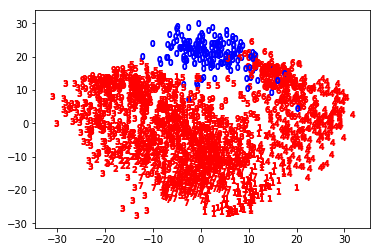

In [55]:
for point, number in zip(features, labels):
    marker = '$%d$' % number
    plt.scatter(point[0], point[1], marker = marker, color = 'blue' if number == 0 else 'red')
plt.show()

In [56]:
pca.explained_variance_ratio_

array([0.14890594, 0.13618771])

In [57]:
targets = (labels == 0).astype(np.int)

In [58]:
df = pd.DataFrame({'pc_1': features[:, 0], 'pc_2': features[:, 1],
                   'label': labels, 'target': targets})

In [51]:
features = df.drop(columns=['label', 'target'])

In [62]:
X, X_test, Y, Y_test = train_test_split(features, targets, test_size = 0.25)

In [63]:
X = pd.DataFrame({'pc_1': X[:, 0], 'pc_2': X[:, 1],
                  'target': Y})
X_test = pd.DataFrame({'pc_1': X_test[:, 0], 'pc_2': X_test[:, 1],
                  'target': Y_test})

In [64]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('target ~ pc_1 + pc_2', 
                            X, family = pm.glm.families.Binomial())
    trace_logistic = pm.sample(2000, chains = 2, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pc_2, pc_1, Intercept]
The acceptance probability does not match the target. It is 0.8939650407208863, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023F153BE470>,
      dtype=object)

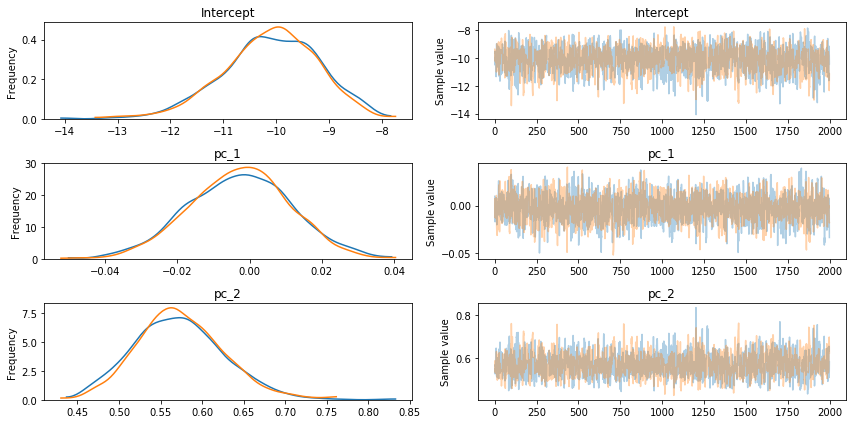

In [65]:
pm.traceplot(trace_logistic)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023F14F07828>,
      dtype=object)

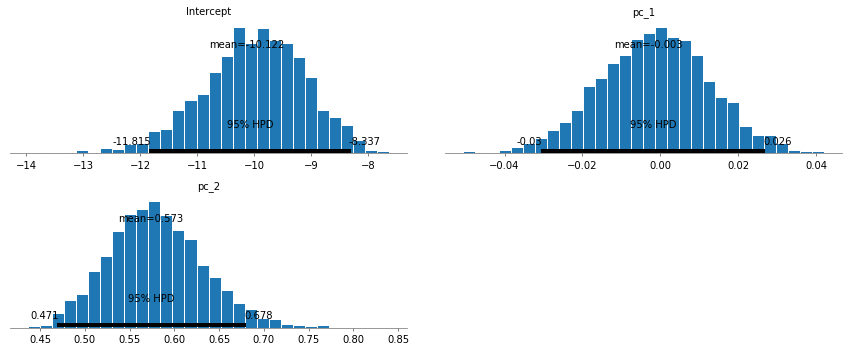

In [66]:
pm.plot_posterior(trace_logistic)

In [71]:
trace_logistic.varnames

['Intercept', 'pc_1', 'pc_2']

In [72]:
def evaluate_trace(trace):
    var_dict = {}
    for var in trace.varnames:
        var_dict[var] = np.mean(trace[var])
    return var_dict

In [73]:
log_vars = evaluate_trace(trace_logistic)

In [74]:
log_vars

{'Intercept': -10.122336548655056,
 'pc_1': -0.0029499530337189746,
 'pc_2': 0.5732150870297833}

In [76]:
predictions = []
for _, obs in X_test.iterrows():
    predictions.append(obs[0] * log_vars['pc_1'] + obs[1] * log_vars['pc_2'] + log_vars['Intercept'])
    

In [80]:
np.where(np.array(predictions) > 1)

(array([ 18,  25,  37,  56,  58,  64,  71,  81,  89, 104, 125, 138, 143,
        150, 152, 187, 197, 227, 230, 233, 243, 257, 277, 280, 287, 303,
        319, 374, 380, 387, 391, 396, 413, 443], dtype=int64),)

In [82]:
np.where(X_test['target'])

(array([  7,  25,  37,  56,  58,  71,  81,  89, 101, 104, 110, 125, 143,
        150, 152, 187, 193, 197, 227, 230, 233, 257, 270, 277, 280, 287,
        304, 319, 360, 374, 380, 387, 391, 396, 406, 413, 443], dtype=int64),)

In [84]:
pc1 = np.linspace(-30, 30, 1000)
pc2 = np.linspace(-30, 30, 1000)

y = pc1 * log_vars['pc_1'] + pc2 * log_vars['pc_2'] + log_vars['Intercept']

In [87]:
colors = ['blue' if  i > 1 else 'red' for i in y]

In [106]:
xx, yy = np.meshgrid(pc1, pc2)
y = xx * log_vars['pc_1'] + yy * log_vars['pc_2'] + log_vars['Intercept']

In [107]:
y[np.where(y > 1)] = 1

In [108]:
y[np.where(y < 1)] = 0

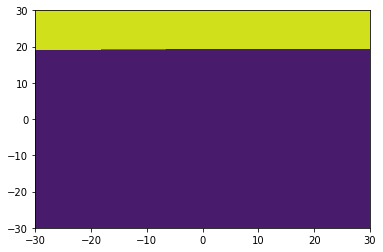

In [109]:
plt.contourf(pc1, pc2, y)